In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
from scipy.interpolate import griddata

In [3]:
from scipy.special import gammainc

In [4]:
connectivity_min, connectivity_max = 0,15
delay_min, delay_max = 0,5
# random_input_span = (1.2,2.8)
random_input_span = (9.5,9.5)
total_time = 100
alpha = 20
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational','Non_repulsive_rotational']
neuron_model = current_models[2]

model_folder_name = neuron_model+'_ensembles'
version = '_v2.0'
# version = '_v1.0'
# version = '_cluster_computed'

# Capture related ensembles

In [5]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [6]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1]) + version
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [7]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}
field_max_intensity_mod_glossary_dict = {}

In [8]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    if g > connectivity_max or g < connectivity_min: continue #check if this connectivity is requested
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    field_max_intensity_mod_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        if delay > delay_max or delay < delay_min: continue #check if this connectivity is requested
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
            field_max_intensity_mod_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_properties.txt') ) as file:
                info_line = file.readline()
                field_period = float( info_line.split(',')[0] )
                max_intensity_mod = float( info_line.split(',')[1] )
                field_period_glossary_dict[g][delay].append( field_period )
                field_max_intensity_mod_glossary_dict[g][delay].append( max_intensity_mod )

            if neuron_model in ['Rotational','Non_repulsive_rotational']: #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(np.abs( field_period_glossary_dict[g][delay] ) )
        field_max_intensity_mod_glossary_dict[g][delay] = np.mean(field_max_intensity_mod_glossary_dict[g][delay])
        if neuron_model in ['Rotational','Non_repulsive_rotational']:amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


In [9]:
def dict_to_dataframe(input_dict):
    table = pd.DataFrame.from_dict(input_dict)
    table.index.name = 'delay'
    table.columns.name = 'connectivity'
    table = table.sort_index(axis=1)
    return table

def nested_dict_to_vectors(given_dict):
    coordinates = []
    for x in given_dict:
        for y in given_dict[x]:
            coordinates.append([x,y,given_dict[x][y]])
    return np.array(coordinates).T

def create_contour_phase_space(given_dict, title, plot_points = False):
    fig = plt.figure()
    ax = fig.add_subplot()
    
    grid_x, grid_y = np.mgrid[g_arr[0]:g_arr[-1]:500j, delay_arr[0]:delay_arr[-1]:500j]
    
    points = nested_dict_to_vectors(given_dict)[0:2].T
    values = nested_dict_to_vectors(given_dict)[2]
    grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

    extent = [min(g_arr),max(g_arr),min(delay_arr),max(delay_arr)]    
    
    filtered_grid = median_filter(grid_z.T, size = 20)
    
    ax.contourf(filtered_grid, extent = extent, cmap = 'inferno')
    C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)
    ax.clabel(C, inline=1, fontsize=10)
    
    if plot_points == True: ax.plot(points[:,0], points[:,1], 'w.', ms=1)
    
    ax.set_title('{} phase space'.format(title))
    ax.set_xlabel('Connectivity')
    ax.set_ylabel('Delay (s)')
    plt.close()
    return fig, ax

In [10]:
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)

In [11]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
g_arr = np.sort( sigma_table.columns )
delay_arr = np.sort( sigma_table.index )

In [12]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

# Sigma dataframe

In [13]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
sigma_table

connectivity,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,...,12.75,13.00,13.25,13.50,13.75,14.00,14.25,14.50,14.75,15.00
delay,,,,,,,,,,,,,,,,,,,,,
0.00,0.033893,0.031096,0.026576,0.022088,0.029660,0.024493,0.023932,0.020122,0.023735,0.020674,...,0.017209,0.013408,0.013585,0.014838,0.015341,0.014443,0.015416,0.014387,0.016559,0.012971
0.10,0.044641,0.029738,0.034968,0.021958,0.020959,0.026439,0.028989,0.026776,0.037041,0.033404,...,0.436734,0.437853,0.439437,0.439952,0.440793,0.441504,0.442286,0.442482,0.442508,0.443031
0.20,0.030575,0.036061,0.033927,0.030342,0.024635,0.040047,0.026412,0.025527,0.037627,0.019700,...,NaN,0.554790,NaN,0.552624,NaN,0.548994,NaN,0.549214,NaN,0.547381
0.25,0.027186,0.027290,0.027305,0.028033,0.029033,0.033659,0.033513,0.034172,0.031204,0.027918,...,NaN,0.577079,NaN,0.575267,NaN,0.571934,NaN,0.571036,NaN,0.567392
0.30,0.029339,0.028034,0.029129,0.037832,0.033665,0.031264,0.034325,0.023595,0.030692,0.028286,...,NaN,0.600282,NaN,0.597601,NaN,0.595037,NaN,0.591633,NaN,0.590262
0.40,0.032000,0.029989,0.026752,0.025472,0.026086,0.044308,0.031938,0.044330,0.030091,0.036780,...,NaN,0.626380,NaN,0.623432,NaN,0.615990,NaN,0.615743,NaN,0.613338
0.50,0.027310,0.026418,0.026290,0.026715,0.028313,0.032845,0.037667,0.039019,0.036829,0.041273,...,NaN,0.640753,NaN,0.637013,NaN,0.633840,NaN,0.625868,NaN,0.625830
0.75,0.027310,0.026494,0.024682,0.023427,0.024313,0.029998,0.036482,0.036594,0.032947,0.032409,...,NaN,0.667501,NaN,0.660045,NaN,0.659881,NaN,0.649940,NaN,0.643294
1.00,0.027359,0.027031,0.027327,0.027333,0.028301,0.031953,0.031754,0.032472,0.024982,0.021614,...,NaN,0.674335,NaN,0.668325,NaN,0.664830,NaN,0.664793,NaN,0.656054


C:\Users\mohsen\AppData\Local\Temp/ipykernel_2928/2442720307.py:7: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))


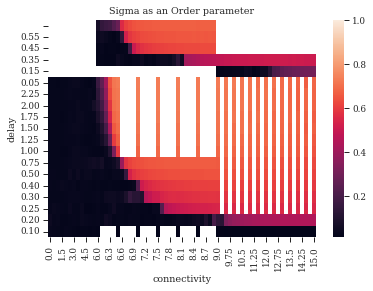

In [14]:
yticklabels = ['{:.2f}'.format(x) for x in sigma_table.index.to_list()]
ax_sigma = sns.heatmap(sigma_table, annot=False, vmax = 1)

ax_sigma.set_title('Sigma as an Order parameter')
ax_sigma.invert_yaxis()

ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))

In [15]:
fig = ax_sigma.get_figure()
fig.savefig(os.path.join(target_path, 'sigma_phase_space.png'), dpi = 1000)

C:\Users\mohsen\AppData\Local\Temp/ipykernel_2928/2812633561.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


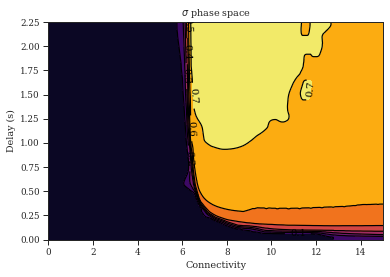

In [16]:
c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$')
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

C:\Users\mohsen\AppData\Local\Temp/ipykernel_2928/2812633561.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


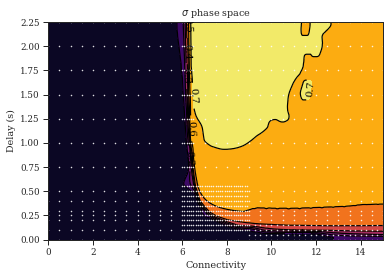

In [17]:
c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$', plot_points = True)
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_points_plotted_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

C:\Users\mohsen\AppData\Local\Temp/ipykernel_2928/2812633561.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


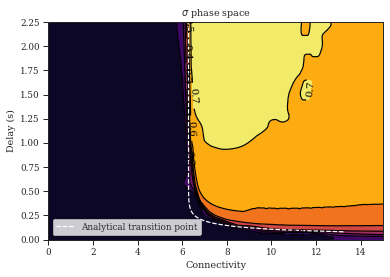

In [53]:
c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$', plot_points = False)

delay_mesh = np.arange(min(delay_arr)+0.08,max(delay_arr),0.01)
g_star = np.zeros_like(delay_mesh)
for i,d in enumerate(delay_mesh):
    g_star[i] = 2*np.pi/gammainc(2,alpha*d*1)

c_ax.plot( g_star, delay_mesh, 'w--', label = 'Analytical transition point')
c_ax.legend(loc='lower left')
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_analytical_trans_points_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

C:\Users\mohsen\AppData\Local\Temp/ipykernel_2928/2812633561.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


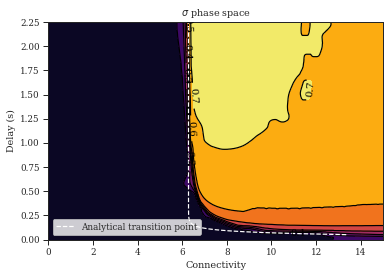

In [51]:
c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$', plot_points = False)

delay_mesh = np.arange(0.05,max(delay_arr),0.01)
g_star_three = np.zeros_like(delay_mesh)
k=2
for i,d in enumerate(delay_mesh):
    D = alpha*d
    g_star_three[i] = 2*np.pi*gammainc(2,(k+2)*D)**(k+1)/gammainc(2,k*D)**k

c_ax.plot( g_star_three, delay_mesh, 'w--', label = 'Analytical transition point')

c_ax.legend(loc='lower left')
# c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_analytical_trans_points_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

C:\Users\mohsen\AppData\Local\Temp/ipykernel_2928/2812633561.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


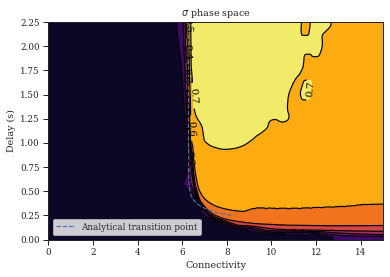

In [43]:
c_fig, c_ax = create_contour_phase_space(sigma_glossary_dict, r'$\sigma$', plot_points = False)

delay_mesh = np.arange(0.25,max(delay_arr),0.01)
g_star_two = np.zeros_like(delay_mesh)
for i,d in enumerate(delay_mesh):
    D = alpha*d
    g_star_two[i] = 2*np.pi*gammainc(2,D)/(1 - np.e**(-D)*(D**3+3*D**2+6*D+6)/6)

c_ax.plot( g_star_two, delay_mesh, 'b--', label = 'Analytical transition point')

c_ax.legend(loc='lower left')
# c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour_analytical_trans_points_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

# Amin Saman Parameter

C:\Users\mohsen\AppData\Local\Temp/ipykernel_2928/2812633561.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


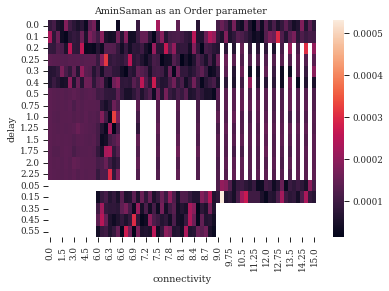

In [19]:
if neuron_model in ['Rotational','Non_repulsive_rotational']:
    amin_saman_param_table = dict_to_dataframe(amin_saman_param_glossary_dict)
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')
    fig = ax_field_period.get_figure()
    fig.savefig(os.path.join(target_path, 'amin_saman_phase_space.png'))
    
    c_fig, c_ax = create_contour_phase_space(amin_saman_param_glossary_dict, 'AminSaman')
    c_fig.savefig(os.path.join(target_path, 'amin_saman_phase_space_contour.png'), dpi = 1000)

# Field period dataframe

In [20]:
field_period_table = dict_to_dataframe(field_period_glossary_dict)
field_period_table

connectivity,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,...,12.75,13.00,13.25,13.50,13.75,14.00,14.25,14.50,14.75,15.00
delay,,,,,,,,,,,,,,,,,,,,,
0.00,0.662252,0.714286,0.191571,0.409836,0.436681,0.925926,0.325733,1.030928,0.180505,0.378788,...,0.222717,0.246347,0.186916,0.181503,0.175747,0.296419,0.215983,0.182316,0.170358,0.205391
0.10,0.662252,0.714286,0.769231,0.819672,0.290698,0.462963,0.487805,0.515464,0.540541,0.378788,...,0.480769,0.485437,0.490196,0.495050,0.502513,0.507614,0.512821,0.518135,0.523560,0.527708
0.20,0.662252,0.238095,0.383142,0.409836,0.217865,0.925926,0.487805,0.515464,0.540541,0.568182,...,NaN,0.800000,NaN,0.819672,NaN,0.840336,NaN,0.854701,NaN,0.869565
0.25,0.662252,0.714286,0.763359,0.819672,0.869565,0.141243,0.970874,0.258398,0.540541,0.568182,...,NaN,0.925926,NaN,0.943396,NaN,0.970874,NaN,0.990099,NaN,1.010101
0.30,0.662252,0.714286,0.769231,0.819672,0.869565,0.925926,0.980392,1.030928,0.540541,1.136364,...,NaN,1.111111,NaN,1.136364,NaN,1.162791,NaN,1.190476,NaN,1.204819
0.40,0.662252,0.357143,0.383142,0.819672,0.869565,0.925926,0.325733,1.030928,1.075269,1.136364,...,NaN,1.408451,NaN,1.449275,NaN,1.492537,NaN,1.515152,NaN,1.562500
0.50,0.662252,0.714286,0.383142,0.819672,0.869565,0.141243,0.970874,1.030928,1.075269,1.136364,...,NaN,1.694915,NaN,1.724138,NaN,1.754386,NaN,1.818182,NaN,1.851852
0.75,100.000000,100.000000,3.225806,2.325581,2.040816,0.141243,0.325733,0.515464,1.724138,0.568182,...,NaN,2.439024,NaN,2.500000,NaN,2.564103,NaN,2.631579,NaN,2.702703
1.00,100.000000,100.000000,4.000000,2.941176,2.631579,2.500000,2.380952,2.325581,2.222222,2.222222,...,NaN,3.225806,NaN,3.333333,NaN,3.333333,NaN,3.448276,NaN,3.571429


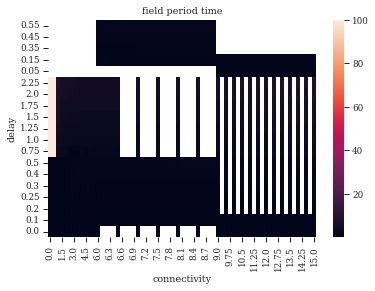

In [21]:
# ax_field_period = sns.heatmap(np.log(field_period_table.abs()), annot=False, vmax = 2, vmin = -2)
ax_field_period = sns.heatmap(field_period_table.abs(), annot=False)
ax_field_period.set_title('field period time')
ax_field_period.invert_yaxis()

In [22]:
fig = ax_field_period.get_figure()
fig.savefig(os.path.join(target_path, 'field_period_phase_space.png'))

C:\Users\mohsen\AppData\Local\Temp/ipykernel_2928/2812633561.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


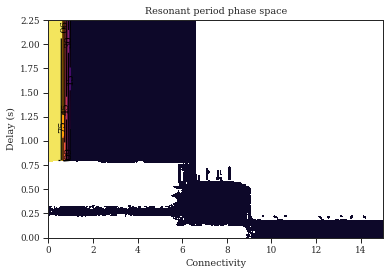

In [23]:
c_fig, c_ax = create_contour_phase_space(field_period_table.abs().to_dict(), 'Resonant period')
c_fig.savefig(os.path.join(target_path, 'field_period_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

In [24]:
max_intensity_table = dict_to_dataframe(field_max_intensity_mod_glossary_dict)
max_intensity_table.head()

connectivity,0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,...,12.75,13.00,13.25,13.50,13.75,14.00,14.25,14.50,14.75,15.00
delay,,,,,,,,,,,,,,,,,,,,,
0.00,125.627152,134.796030,64.103979,59.686552,123.483556,78.431597,76.735508,51.331537,61.456680,84.521945,...,50.830292,31.516561,38.649236,38.896979,36.803157,33.623532,38.094685,33.807000,71.260148,32.521858
0.10,260.847920,126.681687,141.172306,90.647229,58.086183,121.672429,102.344115,106.105571,182.211003,173.904713,...,2481.691541,2970.639769,2464.520669,2162.748209,2471.536276,2661.708015,2876.433040,2772.424277,2448.157909,2206.377196
0.20,85.778273,139.518988,129.314881,128.036797,74.708003,190.717329,82.601171,113.366786,175.137339,53.872105,...,NaN,2703.864749,NaN,3571.943281,NaN,2782.386147,NaN,3494.653414,NaN,2679.787677
0.25,105.857290,116.759889,103.893936,102.546973,115.058300,101.829451,81.342716,91.962917,83.551526,85.434070,...,NaN,2899.812330,NaN,2987.571114,NaN,3645.584306,NaN,3036.486633,NaN,3497.514166
0.30,142.537033,133.462541,116.806185,193.771827,127.164792,137.658092,108.441722,108.842681,132.224385,155.043935,...,NaN,3815.472417,NaN,3771.842114,NaN,3655.246753,NaN,3166.895924,NaN,2453.308285


C:\Users\mohsen\AppData\Local\Temp/ipykernel_2928/2812633561.py:30: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(filtered_grid, extent = extent, colors='black', linewidth=.5)


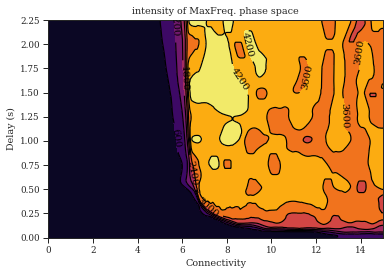

In [25]:
c_fig, c_ax = create_contour_phase_space(field_max_intensity_mod_glossary_dict, 'intensity of MaxFreq.')
c_fig.savefig(os.path.join(target_path, 'max_intensity_phase_space_contour_alpha{}.png'.format(alpha)), dpi = 1000)
c_fig

In [26]:
# %matplotlib notebook
# from mpl_toolkits.mplot3d import Axes3D

# d_arr = max_intensity_table.index
# g_arr = max_intensity_table.columns
# bars_pos = np.array([np.tile(g_arr, len(d_arr)), np.repeat(d_arr, len(g_arr)), [0]*(len(d_arr)*len(g_arr))])

# dd_arr = d_arr[1] - d_arr[0]
# dg_arr = g_arr[1] - g_arr[0]

# dmax_intensity = max_intensity_table.to_numpy().flatten()

# cmap = plt.cm.get_cmap('magma') # Get desired colormap - you can change this!
# period_arr = field_period_table.to_numpy().flatten()
# max_height = np.max(period_arr)   # get range of colorbars so we can normalize
# min_height = np.min(period_arr)
# # scale each z to [0,1], and get their rgb values
# rgba = [cmap( np.log( k ) ) for k in period_arr] 


# fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
# # ax = fig.add_subplot(111, projection='3d')
# # ax.bar3d(bars_pos[0], bars_pos[1], bars_pos[2], dg_arr, dd_arr, dmax_intensity, color=rgba)